In [176]:
# basic imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import json
import math
import seaborn as sns
import ast
from collections import Counter
import networkx as nx
from pathlib import Path
import subprocess

# stats imports
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
from scipy.stats import kstest
from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import boxcox

# regression imports
from statsmodels.stats import diagnostic
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import mixedlm

# src imports
from src.utils import cleaning
from src.utils import tokenization
from src.utils import filling
from src.utils import cluster_search
from src.utils import add_features
from src.data.continents_clusters import regions

# Data loading

In [177]:
# data path
DATA = './data/'

# movie metadata loading
df_movies = pd.read_csv(DATA + 'movie.metadata.tsv', sep='\t', header=None)
df_movies.columns = ['wikipedia_id', 'freebase_id', 'title', 'release_date', 'revenue', 
                     'runtime', 'spoken_languages', 'countries', 'genres']

# charcaters metadata loading
df_characters = pd.read_csv(DATA + 'character.metadata.tsv', sep='\t', header=None)
df_characters.columns = ['wikipedia_id', 'freebase_id', 'release_date', 'character_name', 'actor_birth',
                     'actor_gender', 'actor_height', 'actor_ethnicity', 'actor_name', 
                     'age_at_release', 'freebase_map', 'freebase_character_id', 'freebase_actor_id']

# plot summaries loading
df_plots = pd.read_csv(DATA + 'plot_summaries.txt', sep='\t', header=None, names=['wikipedia_id', 'plot_summary'])

# TMDB dataset loading
df_tmdb = pd.read_csv(DATA + 'TMDB_movie_dataset_v11.csv')

# ratings datasets loading
df_ratings_link = pd.read_csv(DATA + 'ratings_links.csv', sep=',')
df_ratings_ratings = pd.read_csv(DATA + 'ratings_ratings.csv', sep=',')
df_ratings_imdb = pd.read_csv(DATA + 'title.ratings.tsv', sep='\t')

For now, the plots dataset `df_plots` does not require any cleaning operation, as the dataset presents 0% missing values in its columns with no particular format to standardize. However, the movies and characters dataset do require significant cleaning, as is presented below.

# Movies dataset wrangling

Duplicate movies exist in the movies dataset and are first considered.

In [178]:
# df_movies has duplicates of the same movies based on their title which we will delete, only 5% of all data
df_movies = df_movies.drop_duplicates(subset=['title'])

In [179]:
# the df_tmdb dataframe has many duplicates for titles but these could be movies with the same title that are different or movies that are the same
# but are different in features on these movies
df_tmdb = df_tmdb.drop_duplicates(subset=['imdb_id'])

In [180]:
# Altering the release date feature in the TMDB dataframe and in the moves dataframe to match, for unique index creation

# drop movies in each dataframe with missing release dates 
df_movies = df_movies.dropna(subset=['release_date'])
df_tmdb = df_tmdb.dropna(subset=['release_date'])
df_movies['release_date'] = df_movies['release_date'].apply(cleaning.clean_dates)
df_tmdb['release_date'] = df_tmdb['release_date'].apply(cleaning.clean_dates)

title_release_movies = df_movies.title + df_movies.release_date.astype(str)
df_movies_copy = df_movies.copy()
df_movies_copy.index = title_release_movies

title_release_tmdb = df_tmdb.title + df_tmdb.release_date.astype(str)
df_tmdb_copy = df_tmdb.copy()
df_tmdb_copy.index = title_release_tmdb

df_movies_tmdb = pd.merge(df_movies_copy, df_tmdb_copy, left_index=True, right_index=True)

# as the unique index of title and release date was used to merge the dataframes, the original title columns are duplicated and must be removed
df_movies_tmdb = df_movies_tmdb.drop(['title_y'], axis = 1).rename(columns={'title_x': 'title'}) 

With duplicate movies dropped, the TMDB dataset can be merged as to enrich the movie metadata.

In [181]:
# drop some duplicate columns and then rename
df_movies_tmdb = df_movies_tmdb.drop(['spoken_languages_y'], axis = 1).rename(columns={'spoken_languages_x': 'spoken_languages'}) 
df_movies_tmdb = df_movies_tmdb.drop(['genres_y'], axis = 1).rename(columns={'genres_x': 'genres'}) 

In [182]:
# cleaning 'spoken_languages', 'countries', 'genres' df_movies columns in df_movies_tmdb
df_movies_tmdb['spoken_languages'] = df_movies_tmdb['spoken_languages'].apply(cleaning.clean_idxs)
df_movies_tmdb['countries'] = df_movies_tmdb['countries'].apply(cleaning.clean_idxs)
df_movies_tmdb['genres'] = df_movies_tmdb['genres'].apply(cleaning.clean_idxs)

In [183]:
# use the release date of the TMDB dataset to fill the release date of a movie if not present in CMU dataset
df_movies_tmdb['release_date_x'] = df_movies_tmdb['release_date_x'].fillna(df_movies_tmdb['release_date_y'])

# drop missing release dates, remove duplicate column and rename release_date_x
df_movies_tmdb = df_movies_tmdb.dropna(subset=['release_date_x'])
df_movies_tmdb = df_movies_tmdb.drop(['release_date_y'], axis = 1)
df_movies_tmdb = df_movies_tmdb.rename(columns={'release_date_x': "release_date"}) 

# filter dates to meaningful ones by keeping the release interval [1888, 2012], since 
# the very first movie was released in 1888 and meaningful data from df_movies is up to 2012
df_movies_tmdb = cleaning.filter_years(df_movies_tmdb, 'release_date')

In [184]:
# use the revenues of the TMDB dataset to fill the revenues of a movie if not present in CMU dataset
df_movies_tmdb['revenue_x'] = df_movies_tmdb['revenue_x'].fillna(df_movies_tmdb['revenue_y'])

# remove duplicate column and rename revenue_x
df_movies_tmdb = df_movies_tmdb.drop(['revenue_y'], axis = 1)
df_movies_tmdb = df_movies_tmdb.rename(columns={'revenue_x': "revenue"}) 

In [185]:
# use the runtimes of the TMDB dataset to fill the runtimes of a movie if not present in CMU dataset
df_movies_tmdb['runtime_x'] = df_movies_tmdb['runtime_x'].fillna(df_movies_tmdb['runtime_y'])

# remove duplicate column and rename runtime_x
df_movies_tmdb = df_movies_tmdb.drop(['runtime_y'], axis = 1)
df_movies_tmdb = df_movies_tmdb.rename(columns={'runtime_x': "runtime"}) 

In [186]:
# remove movies with no genre reported
df_movies_tmdb = df_movies_tmdb.dropna(subset=['genres'])

In [187]:
# dropping movies that have missing IMDB IDs
df_movies_tmdb = df_movies_tmdb.dropna(subset=["imdb_id"])
df_movies_tmdb = df_movies_tmdb.drop(df_movies_tmdb[df_movies_tmdb["imdb_id"] == 'nan'].index)

# IMDB references in df_movies_tmdb are formatted differently than in df_ratings_link
df_movies_tmdb['imdb_id'] = df_movies_tmdb['imdb_id'].apply(cleaning.clean_imdb)

Using the ratings from IMDB to give a ratings feature to our metadata.

In [188]:
# IMDB references in df_ratings_imdb_id are formatted differently than in df_movies_tmdb
df_ratings_imdb['tconst'] = df_ratings_imdb['tconst'].apply(cleaning.clean_imdb)

# giving movie metadata ratings from imdb mean ratings using tmdb as linker as it has imdb ids of movies
df_movies_ratings_imdb = pd.merge(df_movies_tmdb, df_ratings_imdb, left_on='imdb_id', right_on='tconst')

In [189]:
# dropping many useless columns
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['id'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['status'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['vote_average'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['vote_count'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['backdrop_path'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['homepage'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['original_title'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['overview'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['popularity'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['poster_path'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['tagline'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['keywords'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['tconst'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['adult'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['production_countries'], axis = 1)

In [190]:
# replacing the runtime outliers with mean of non-outliers, assuming normality, apply +/- t*IQR of quantiles method
df_movies_ratings_imdb = filling.fill_iqr(df_movies_ratings_imdb, 'runtime', 3.5)

By doing this, we are losing some outliers which might be interesting to study. For example, late 1800s movies have usually very short runtimes and this might be interesting to investigate.

In [191]:
# Dropping missing 'countries' entries
df_movies_ratings_imdb.dropna(subset=['countries'], inplace=True)

# Evaluating movies with more than one country
df_movies_ratings_imdb['country_count'] = df_movies_ratings_imdb['countries'].str.len()
movies_1_country = df_movies_ratings_imdb[df_movies_ratings_imdb['country_count'] == 1.0]
movies_1_or_2_country = df_movies_ratings_imdb[(df_movies_ratings_imdb['country_count'] == 1.0) | (df_movies_ratings_imdb['country_count'] == 2.0)]

movies_1_country_size = movies_1_country.size
movies_1_or_2_country_size = movies_1_or_2_country.size
all_movies = df_movies_ratings_imdb.size

percent_one_country = movies_1_country_size/all_movies
percent_one_or_two_country = movies_1_or_2_country_size/all_movies

print(f"{percent_one_country} of our ratings-populated movie metadataset have only one country listed.")
print(f"{percent_one_or_two_country} of our ratings-populated movie metadataset have one or two countries listed.")

# Keeping movies with one country for further analysis
df_movies_ratings_imdb = movies_1_country
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['country_count'], axis = 1)

0.8652269546090782 of our ratings-populated movie metadataset have only one country listed.
0.961757648470306 of our ratings-populated movie metadataset have one or two countries listed.


In [192]:
# Evaluating movies with more than one genre
df_movies_ratings_imdb['genre_count'] = df_movies_ratings_imdb['genres'].str.len()
movies_1_genre = df_movies_ratings_imdb[df_movies_ratings_imdb['genre_count'] == 1.0]
movies_1_or_2_genre= df_movies_ratings_imdb[(df_movies_ratings_imdb['genre_count'] == 1.0) | (df_movies_ratings_imdb['genre_count'] == 2.0)]
movies_1_to_3_genre= df_movies_ratings_imdb[(df_movies_ratings_imdb['genre_count'] == 1.0) | (df_movies_ratings_imdb['genre_count'] == 2.0) | (df_movies_ratings_imdb['genre_count'] == 3.0)]
movies_1_to_4_genre= df_movies_ratings_imdb[(df_movies_ratings_imdb['genre_count'] == 1.0) | (df_movies_ratings_imdb['genre_count'] == 2.0) | (df_movies_ratings_imdb['genre_count'] == 3.0) | (df_movies_ratings_imdb['genre_count'] == 4.0)]
movies_1_to_5_genre= df_movies_ratings_imdb[(df_movies_ratings_imdb['genre_count'] == 1.0) | (df_movies_ratings_imdb['genre_count'] == 2.0) | (df_movies_ratings_imdb['genre_count'] == 3.0) | (df_movies_ratings_imdb['genre_count'] == 4.0) | (df_movies_ratings_imdb['genre_count'] == 5.0)]
movies_1_to_6_genre= df_movies_ratings_imdb[(df_movies_ratings_imdb['genre_count'] == 1.0) | (df_movies_ratings_imdb['genre_count'] == 2.0) | (df_movies_ratings_imdb['genre_count'] == 3.0) | (df_movies_ratings_imdb['genre_count'] == 4.0) | (df_movies_ratings_imdb['genre_count'] == 5.0) | (df_movies_ratings_imdb['genre_count'] == 6.0)]

movies_1_genre_size = movies_1_genre.size
movies_1_or_2_genre_size = movies_1_or_2_genre.size
movies_1_to_3_genre_size = movies_1_to_3_genre.size
movies_1_to_4_genre_size = movies_1_to_4_genre.size
movies_1_to_5_genre_size = movies_1_to_5_genre.size
movies_1_to_6_genre_size = movies_1_to_6_genre.size
all_movies = df_movies_ratings_imdb.size

percent_one_genre = movies_1_genre_size/all_movies
percent_one_or_two_genre = movies_1_or_2_genre_size/all_movies
percent_one_to_three_genre = movies_1_to_3_genre_size/all_movies
percent_one_to_four_genre = movies_1_to_4_genre_size/all_movies
percent_one_to_five_genre = movies_1_to_5_genre_size/all_movies
percent_one_to_six_genre = movies_1_to_6_genre_size/all_movies

print(f"{percent_one_genre} of our ratings-populated movie metadataset have only one genre listed.")
print(f"{percent_one_or_two_genre} of our ratings-populated movie metadataset have one or two genres listed.")
print(f"{percent_one_to_three_genre} of our ratings-populated movie metadataset have one to three genres listed.")
print(f"{percent_one_to_four_genre} of our ratings-populated movie metadataset have one to four genres listed.")
print(f"{percent_one_to_five_genre} of our ratings-populated movie metadataset have one to five genres listed.")
print(f"{percent_one_to_six_genre} of our ratings-populated movie metadataset have one to six genres listed.")

0.19823203143055235 of our ratings-populated movie metadataset have only one genre listed.
0.3923041368153455 of our ratings-populated movie metadataset have one or two genres listed.
0.5689854402588398 of our ratings-populated movie metadataset have one to three genres listed.
0.7201294199214237 of our ratings-populated movie metadataset have one to four genres listed.
0.8306563438872198 of our ratings-populated movie metadataset have one to five genres listed.
0.9042928125722209 of our ratings-populated movie metadataset have one to six genres listed.


In [193]:
df_movies_ratings_imdb = df_movies_ratings_imdb.explode("genres")

# identifying the 20 most common single genres over all movies
genre_counts = df_movies_ratings_imdb['genres'].value_counts()

# getting the top 20 genres as a list
top_20_genres = genre_counts.head(20).index.tolist()

# removing irrelevant genre rows from the movies metadataset
df_movies_ratings_imdb = df_movies_ratings_imdb[df_movies_ratings_imdb['genres'].isin(top_20_genres)]

# the spoken languages, countries and genres columns needs to quickly be cleaned
df_movies_ratings_imdb["spoken_languages"] = df_movies_ratings_imdb["spoken_languages"].apply(lambda x: ",".join(map(str, x))  if type(x) == list else x)
df_movies_ratings_imdb["countries"] = df_movies_ratings_imdb["countries"].apply(lambda x: ",".join(map(str, x))  if type(x) == list else x)
df_movies_ratings_imdb["genres"] = df_movies_ratings_imdb["genres"].str.lower()

Dealing with multiple genres movies is not trivial. Exploding multiple-genres movies might be a solution but one needs to be careful about the influence of this on the overall statistics of the dataframe. A quick analysis on the #genres distribution shows the latter to be left-skewed, this implies that generally a movie has a low number of genres when this is larger than 1. This could justisfy the choice of exploding multiple genres movies. For later on analysis, a possible solution would be to choose unique movies starting from the standard movies dataframe, selecting a multiple repeated times movie based on the most relevant genre among the ones that belong to it.

The movie metadata wrangling is considered finished, and baseline visualizations of attributes within help in visualizing their contained data.

In [194]:
df_movies_tmdb_ratings = df_movies_ratings_imdb.copy()

# final ordering of the standard dataframe
df_movies_tmdb_ratings = df_movies_tmdb_ratings.sort_values(by='title')

# in the 'revenue' column, substitute 0.0 with nan for clarity
df_movies_tmdb_ratings['revenue'] = df_movies_tmdb_ratings['revenue'].replace(0.0, None)

# convert 'revenue' column to numeric values, raise error message in case of problems
df_movies_tmdb_ratings['revenue'] = pd.to_numeric(df_movies_tmdb_ratings['revenue'], errors='coerce')

In [195]:
# in the 'budget' column, substitute 0.0 with nan for clarity
df_movies_tmdb_ratings['budget'] = df_movies_tmdb_ratings['budget'].replace(0.0, None)

The final standard dataframe for movies data is `df_movies_tmdb_ratings`. The only columns which present some missing values are, in ascending order of missing data: `budget`, `'spoken_languages'` (recall that `'original_language'` with 0% missing data is available), `'production_companies'`, `'revenue'`.

In [196]:
unique_titles_now = len(df_movies_tmdb_ratings['title'].unique())
unique_titles_before = len(df_movies)
print(f"There are now {unique_titles_now} unique movies in the standard movies dataset.")
print(f"There were {unique_titles_before} unique movies in the initial movies dataset.")

There are now 32543 unique movies in the standard movies dataset.
There were 68978 unique movies in the initial movies dataset.


### Adding `region` Column to the Master Dataframe

Part of our analysis involves considering geographical groupings, which have been manually clustered by production region.

In [197]:
# dictionary to map each country to a continent
country_to_region = {}
for region, countries in regions.items():
    for country in countries:
        country_to_region[country] = region

# Map the 'countries' column to the 'region' column
df_movies_tmdb_ratings['region'] = df_movies_tmdb_ratings['countries'].map(country_to_region)

# since df_movies_tmdb_ratings[df_movies_tmdb_ratings['continent'].isna()] shows that 2 entries
# have not been assigned to a continent, a quick check allows to see that this is due to an error 
# in the country (the specific movie is 'The Flying Scotsman'). These entries are therefore dropped
df_movies_tmdb_ratings = df_movies_tmdb_ratings.dropna(subset=['region'])

# Historical Proximity Score

The dataframe must be filled manually. Entries are in range from -1 to 1. 
Taking into account that a movie takes minimum a year to produce (in general), if a meaningful historical event happens, a score of 1 is given to the exact year of the event and the year later, then the score lowers by 0.2 each year. Therefore, an historical event has a decreasing impact on movies for the next 5 years. If the event is positive, the score is positive, viceversa if the event is negative. Events for each country are asked to ChatGPT.

In [198]:
# saving df_movies_tmdb_ratings as a pickle file
output_path = Path("src/scripts/df_movies_tmdb_ratings.pkl")
df_movies_tmdb_ratings.to_pickle(output_path)

# running historical_proximity.py script
result = subprocess.run(["python", "src/scripts/historical_proximity.py"], capture_output=True, text=True)

# if the script failed, print the error message
if result.returncode != 0:
    print("Error occurred:")
    print(result.stderr)
else:
    print("Script ran successfully.")

# loading historical_proximity_score
historical_proximity_score = pd.read_pickle("src/scripts/historical_proximity_score.pkl")

Script ran successfully.


In [199]:
# checking if there are any rows with only zeros
rows_with_zeros = historical_proximity_score.loc[(historical_proximity_score == 0).all(axis=1)]

if not rows_with_zeros.empty:
    print("There are rows with only zeros.")
else:
    print("No rows with only zeros.")

There are rows with only zeros.


In [200]:
# adding historical_proximity_score column
df_movies_tmdb_ratings['historical_proximity_score'] = df_movies_tmdb_ratings.apply(
    lambda row: add_features.get_historical_proximity_score(row, historical_proximity_score), axis=1
)

## Defining a master movies dataset
`df_movies_tmdb_ratings` is now one of the master dataframes. Since two columns have been exploded (`genres`, `revenues`) statistics might have been altered. Therefore, a smaller dataframe containing only unique titles must be defined to analyze features such as `revenue` or the ratings-related ones. Unique titles rows with the smallest amount of missing values among columns will be selected. This final master dataframe is `df_movies_tmdb_ratings_unique`.

In [201]:
df_movies_tmdb_ratings_unique = cleaning.drop_most_missing(df_movies_tmdb_ratings, ['title'])

# drop 'missing_values' column of df_movies_tmdb_ratings
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(columns=['missing_values'])

# dropping duplicates (just in case there are any duplicates after the selection process)
df_movies_tmdb_ratings_unique = df_movies_tmdb_ratings_unique.drop_duplicates(subset='title')

# Characters Dataset Cleaning

Analogous to the movie metadata, the characters dataset must be wrangled.

In [202]:
# clean characters 'release_date' and 'actor_birth' to keep the release year only
df_characters['release_date'] = df_characters['release_date'].apply(cleaning.clean_dates)
df_characters['actor_birth'] = df_characters['actor_birth'].apply(cleaning.clean_dates)

The datastory will most focus on actor ethnicity, therefore particular attention is payed to the related columns in `df_characters`.

In [203]:
# counting the number of unique values in 'actor_ethnicity', excluding NaN
print(f"Number of unique ethnicities in 'actor_ethnicity': {df_characters['actor_ethnicity'].nunique(dropna=True)} \n")

# counting the number of NaN values in 'actor_ethnicity'
print(f"Number of NaN values in 'actor_ethnicity': {df_characters['actor_ethnicity'].isna().sum()}")

# total number of entries in 'actor_ethnicity' column
print(f"Total entries in 'actor_ethnicity': {len(df_characters['actor_ethnicity'])}")

# NaN entries proportion
nan_proportion_ethnicity = df_characters['actor_ethnicity'].isna().sum() / len(df_characters['actor_ethnicity'])
print(f"Proportion of NaN values in 'actor_ethnicity': {nan_proportion_ethnicity:.2%}")

Number of unique ethnicities in 'actor_ethnicity': 479 

Number of NaN values in 'actor_ethnicity': 344611
Total entries in 'actor_ethnicity': 450669
Proportion of NaN values in 'actor_ethnicity': 76.47%


Actors' ethnicities are in the format of Freebase IDs. To translate them, these unique IDs have been saved in a `.txt` file, which has been translated using `query.wikidata.org` by executing the following SPARQL request:

```sparql
SELECT DISTINCT ?freebase_id ?wikidata_id ?label WHERE {
  VALUES ?freebase_id {
    "/m/05bzpzx" "/m/064rb5l" "/m/01km_m" "/m/059v8" "/m/03b_13l" "/m/09c8kp" "/m/05ztd1" 
    "/m/04c28" "/m/03sk2" "/m/04jtjvt" "/m/03hjx6f" "/m/027936c" "/m/03nvq" "/m/03nz70" 
    "/m/01g3rx" "/m/02wz7j" "/m/04kdwcx" "/m/04_8lfc" "/m/033qt1" "/m/08j1fb" "/m/07wsyr" 
    "/m/06vb7b" "/m/012fh" "/m/0dm3xpw" "/m/09r2kh" "/m/02ry8mk" "/m/029q52" "/m/026d074" 
    "/m/013y54"
    # Add more IDs as needed
  }
  ?wikidata_id wdt:P646 ?freebase_id.
  ?wikidata_id rdfs:label ?label.
  FILTER(LANG(?label) = "en")
}

The creation of the `.txt` file is achieved by `src/data/freebase_to_batches.py` and the result is `src/data/unique_actor_ethnicities_batexhes.txt`. The outputs from query.wikidata.org have been saved in a .csv file (`freebaseids_labels.csv`)

In [204]:
# defining src/data/ path
SRC_DATA = './src/data/'

# reading the .csv and saving it to a dataframe
df_labels = pd.read_csv(SRC_DATA + 'freebaseids_label.csv')
df_labels.columns = ['freebase_id', 'wikipedia_id', 'label']  

# mapping dictionary definition
freebase_to_label = dict(zip(df_labels['freebase_id'], df_labels['label']))

# creating 'ethnicity_label' column where to map the freebse ethnicity Ids to the 
# corresponding labels
df_characters['ethnicity_label'] = df_characters['actor_ethnicity'].map(freebase_to_label)

In [205]:
# calculating the proportion of nans in 'ethnicity_label'
nan_proportion_label = df_characters['ethnicity_label'].isna().sum() / len(df_characters['ethnicity_label'])

# checking if any information have been lost during the ids-label translation
print(f"Proportion of NaN values in 'actor_ethnicity': {nan_proportion_ethnicity:.2%}")
print(f"Proportion of NaN values in 'ethnicity_label': {nan_proportion_label:.2%}")

Proportion of NaN values in 'actor_ethnicity': 76.47%
Proportion of NaN values in 'ethnicity_label': 77.17%


In [206]:
# printing some of the counts of unique values in 'ethnicity_label', excluding NaN
print("Unique values in 'ethnicity_label' and their counts:")
print(df_characters['ethnicity_label'].value_counts(dropna=True).head(10)) 

Unique values in 'ethnicity_label' and their counts:
ethnicity_label
Indians               16351
African Americans     10159
Jewish people         10121
English people         6165
Irish Americans        3857
Italian Americans      2956
White people           2307
White Americans        2250
Scottish Americans     2223
Irish people           1637
Name: count, dtype: int64


### Clustering Ethnicities & Adding Nationalities & Ethnicities from Wikidata:

In [207]:
# Load the dictionary from the .txt file
with open(SRC_DATA + "ethnicities_clusters.txt", "r") as file:
    ethnicities_clusters = ast.literal_eval(file.read())

In [208]:
#defining the ethnicity_to_clusters dictionary
ethnicity_to_clusters = {}
for cluster, labels in ethnicities_clusters.items():
    for label in labels:
        #checking if the label is already in the dictionary
        if label not in ethnicity_to_clusters:
            # init a new empty list
            ethnicity_to_clusters[label] = []
        # Add the cluster if not already in the list to avoid duplicates
        if cluster not in ethnicity_to_clusters[label]:
            ethnicity_to_clusters[label].append(cluster)

# Map each character's ethnicity to its unique clusters
df_characters['mapped_clusters'] = df_characters['ethnicity_label'].apply(
    lambda ethnicity: ethnicity_to_clusters.get(ethnicity, [])
)


In [209]:
# searching unique ethnicity labels where 'mapped_clusters' is missing
unmatched_ethnicities = df_characters[df_characters['mapped_clusters'].isna()]['ethnicity_label'].unique()

Since the labels are still incomplete for a large part, information from wikidata is adopted to enrich the `df_characters` dataframe. For each actor (using his freebase_id), a query has been requested to retrieve ethnicity or nationality if available. Everything is saved in `wikidata_actor_info.csv`.

In [210]:
# reading the .csv as a dataframe
df_wikidata = pd.read_csv(SRC_DATA + 'wikidata_actor_info.csv', sep=',')

# left merging df_characters and df_wikidata
df_characters = pd.merge(df_characters, df_wikidata, left_on="freebase_actor_id", right_on="freebaseID", how="left")

In [211]:
# Filling 'ethnicity_label', where necessary, with the new labels extracted from wikidata
# (either 'ethnicityLabel' or 'nationalityLabel' if the first is NaN or ambiguous)
def fill_ethnicity(row):
    if row['ethnicity_label'] in unmatched_ethnicities:
        # If the ethnicity is ambiguous, retrieve the nationality
        return row['nationalityLabel'] if pd.notna(row['nationalityLabel']) else (
            row['ethnicityLabel'] if pd.notna(row['ethnicityLabel']) else row['ethnicity_label'])
    else:
        # For non-ambiguous cases, retrieve the ethnicity label associated to it or fallback to nationality
        return row['ethnicity_label'] if pd.notna(row['ethnicity_label']) else (
            row['ethnicityLabel'] if pd.notna(row['ethnicityLabel']) else row['nationalityLabel']
        )

df_characters['ethnicity_label'] = df_characters.apply(fill_ethnicity, axis=1)

# printing the final results
print(f"Before filling, the proportion of NaN values in 'ethnicity_label' was: {nan_proportion_label:.2%}")

# re-computing the proportion of nan in 'ethnicity_labels'
nan_proportion_label = df_characters['ethnicity_label'].isna().sum() / len(df_characters['ethnicity_label'])
print(f"After filling, the proportion of NaN values in 'ethnicity_label' is: {nan_proportion_label:.2%}")


Before filling, the proportion of NaN values in 'ethnicity_label' was: 77.17%
After filling, the proportion of NaN values in 'ethnicity_label' is: 36.54%


The proportion of missing values in `'ethnicity_label'` has been halved through filling it with wikidata information. This allows to save a big part of the original dataframe when dropping nan values in the `'ethnicity_label'` column. Now, new ethnicities can be mapped to the clusters in `ethnicities_clusters.txt` file, after updating the latter. Note that, for simplicity, only the last updated version of this file is stored in `/src/data/`, therefore also in the first clustering this version has been adopted. 

In [212]:
new_ethnicity_to_clusters = {}
for cluster, labels in ethnicities_clusters.items():
    for label in labels:
        new_ethnicity_to_clusters.setdefault(label, []).append(cluster)

df_characters['mapped_clusters'] = df_characters['ethnicity_label'].apply(
    lambda ethnicity: list(set(new_ethnicity_to_clusters.get(ethnicity, [])))
)

In [213]:
# Identify unmatched ethnicity labels
unmatched_ethnicities = df_characters[df_characters['ethnicity_label'].apply(
    lambda ethnicity: ethnicity not in ethnicity_to_clusters
)]['ethnicity_label']

# Count occurrences of unmatched ethnicity labels
unmatched_ethnicities_counts = unmatched_ethnicities.value_counts()

# Print the total number of unique unmatched ethnicity labels
print(f"Number of unmatched ethnicity labels: {unmatched_ethnicities_counts.shape[0]}")

# Print unmatched ethnicity labels with their counts
print("Unmatched ethnicity labels and their counts:")
print(unmatched_ethnicities_counts)

Number of unmatched ethnicity labels: 6
Unmatched ethnicity labels and their counts:
ethnicity_label
مسح                        9
multiracial people         4
Q25589681                  4
Karay-a people             2
Bohemian People            1
peoples of the Caucasus    1
Name: count, dtype: int64


For some ambiguous ethnicities, "Jewish People" whose actors may have several ethnicities/nationalities we attributed them to the category middle east as it accounts for Israel too. And Jewish in India were considered Israelian Jews also. Idk if we should precise that. 

In [214]:
# dropping useless columns
#["freebase_id", "character_name", "actor_birth", "actor_height", "freebase_map","actor_ethnicity" ,"freebaseID","actorLabel", "nationalityLabel"], inplace=True)
df_characters= df_characters.drop(['freebaseID'], axis = 1)
df_characters= df_characters.drop(['actorLabel'], axis = 1)
df_characters= df_characters.drop(['ethnicityLabel'], axis = 1)
df_characters= df_characters.drop(['nationalityLabel'], axis = 1)
df_characters= df_characters.drop(['ethnicity_label'], axis = 1)
df_characters= df_characters.drop(['freebase_character_id'], axis = 1)
df_characters= df_characters.drop(['freebase_map'], axis = 1)
df_characters= df_characters.drop(['actor_height'], axis = 1)
df_characters= df_characters.drop(['character_name'], axis = 1)
df_characters=df_characters.drop(['actor_ethnicity'], axis = 1)
df_characters=df_characters.drop(['freebase_id'], axis = 1)

In [215]:
#renaming mapped cluster column
df_characters = df_characters.rename(columns={'mapped_clusters': 'actor_ethnicity'})


- This is the minimum of ambiguous ethnicities we could have. Those will remain inclassified since our analysis focuses on regions. 
- No dropping NA's for now as we will be investigating ethnicities and genders.

In [216]:
#deleting useless dfs
del df_labels
del df_wikidata
del unmatched_ethnicities
del unmatched_ethnicities_counts

## Merging characters with master dataframe for primary plots mainly

In [217]:
#creting new df merging character's data with master dataframe
df_movies_tmdb_ratings_characters = pd.merge(df_characters[['wikipedia_id','actor_gender','actor_ethnicity','freebase_actor_id']],
                             df_movies_tmdb_ratings_unique[['wikipedia_id','countries', 'title', 'release_date','genres','averageRating','numVotes','region']], 
                             on='wikipedia_id', how='inner')


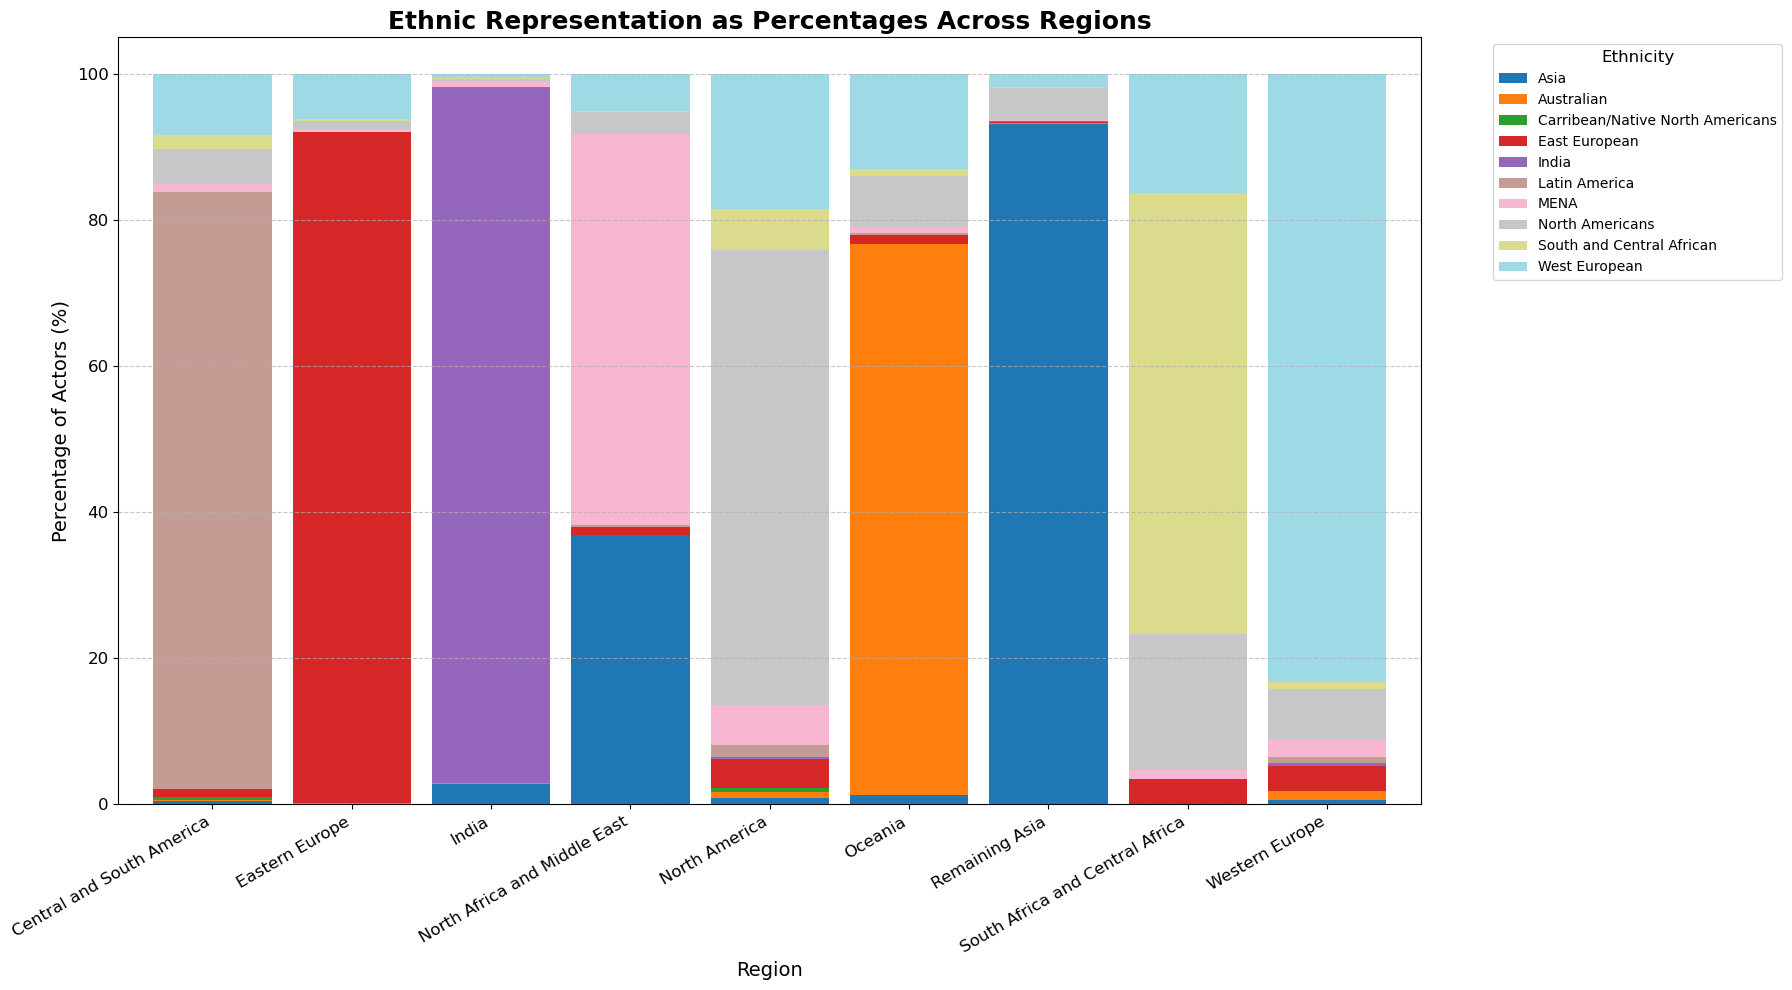

In [218]:
# Filter rows where both 'regions' and 'mapped_clusters' are not NaN
df_characters_region_ethnicity = df_movies_tmdb_ratings_characters.dropna(subset=['region', 'actor_ethnicity'])

# Explode the 'mapped_clusters' column to handle lists
df_characters_region_ethnicity_exploded = df_characters_region_ethnicity.explode('actor_ethnicity')

# Ethnicity representation by region
region_ethnicity_trends = df_characters_region_ethnicity_exploded.groupby(['region', 'actor_ethnicity']).size().unstack(fill_value=0)

# Calculate percentages for each region
region_ethnicity_percent = region_ethnicity_trends.div(region_ethnicity_trends.sum(axis=1), axis=0) * 100

# Plot the stacked bar chart with percentages
plt.figure(figsize=(18, 10))  # Larger figure size for readability
region_ethnicity_percent.plot(kind='bar', stacked=True, colormap='tab20', width=0.85, ax=plt.gca())

# Labeling and layout improvements
plt.xlabel("Region", fontsize=14)
plt.ylabel("Percentage of Actors (%)", fontsize=14)
plt.title("Ethnic Representation as Percentages Across Regions", fontsize=18, fontweight='bold')

# Adjust x-tick rotation for readability
plt.xticks(rotation=30, ha="right", fontsize=12)

plt.yticks(fontsize=12)
plt.legend(title="Ethnicity", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, title_fontsize=12)

# Optional: add horizontal grid lines for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Improve layout
plt.tight_layout()
plt.show()


## Creating the Ethnicity score - using characters dataframe

What interests us is how the demographics of the cast members of one movie may impact it's ratings. We'll look at their ethnicities and their genders. This two features have to be quantified through an ethnicity_score and a gender_score per movie, reflecting not only the proportions but the distribution of the cast. A movie with 10 ethnicities represented equally (balanced distribution) should score higher in diversity than a movie with 10 ethnicities but dominated by one ethnicity. This is where the Shannon Diversity Index (SDI) becomes valuable because we are not capturing the true spread of diversity.
- **Shannon Index** offers a balanced measure of diversity, reducing the impact of outliers and providing a more accurate view of diversity distribution. We will be looking at the entropy of distribution. 
$$
H = - \sum_{i=1}^{n} p_i \ln(p_i)
$$

Where:

- \(H\): Shannon Diversity Index  
- \(p_i\): Proportion of individuals in the \(i\)-th category (ethnicity)  
- \(n\): Total number of categories (ethnicities)  




## 1-Ethnicity Score 

First we create a new dataframe which will contain the movie_id , number of characters of each movie , and proportion of individuals of each ethnicity in each movie, and finally the SDI ethnicity score for each movie. 

In [219]:
#filtering actors with no ethnicities by filtering nans and empty lists
df_filtered = df_characters[
    df_characters['actor_ethnicity'].notna() & df_characters['actor_ethnicity'].apply(lambda x: len(x) > 0)
]

In [220]:
#Df for ethnicity diversity score
df_ethnicity_exploded = df_filtered.explode('actor_ethnicity')

In [221]:
# Occurrences of each ethnicity per movie
ethnicity_counts = df_ethnicity_exploded.groupby(['wikipedia_id', 'actor_ethnicity']).size().reset_index(name='ethnicity_count')
# since df_ethnicity is exploded based on ethnicities, counting the nb of entries simply gives total nb of ethnicities in the movie
total_actors = df_ethnicity_exploded.groupby('wikipedia_id').size().reset_index(name='total_actors')
# Merge counts back into exploded dataframe
df_ethnicity_counts = ethnicity_counts.merge(total_actors, on='wikipedia_id')
# Proportions for each ethnicity
df_ethnicity_counts['ethnicity_proportion'] = df_ethnicity_counts['ethnicity_count'] / df_ethnicity_counts['total_actors']


In [222]:
def shannon_entropy(proportions):
    """
    Calculates the Shannon entropy given a list or series of proportions.
    
    Parameters:
    proportions (list or pd.Series): Proportions of categories in a group.
    
    Returns:
    float: Shannon entropy (diversity index).
    """
    return -np.sum(proportions * np.log(proportions))

In [223]:
# Calculate SDI for each movie
df_sdi = df_ethnicity_counts.groupby('wikipedia_id').apply(
    lambda group: shannon_entropy(group['ethnicity_proportion'])
).reset_index(name='SDI_ethnicity')

# Merge the SDI scores back to the original dataframe
df_ethnicity_counts = df_ethnicity_counts.merge(df_sdi, on='wikipedia_id')

#Drop duplicates for distribution analysis 
df_ethnicity_counts = df_ethnicity_counts.drop_duplicates(subset='wikipedia_id')


C:\Users\bosca\AppData\Local\Temp\ipykernel_21364\3702374300.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sdi = df_ethnicity_counts.groupby('wikipedia_id').apply(


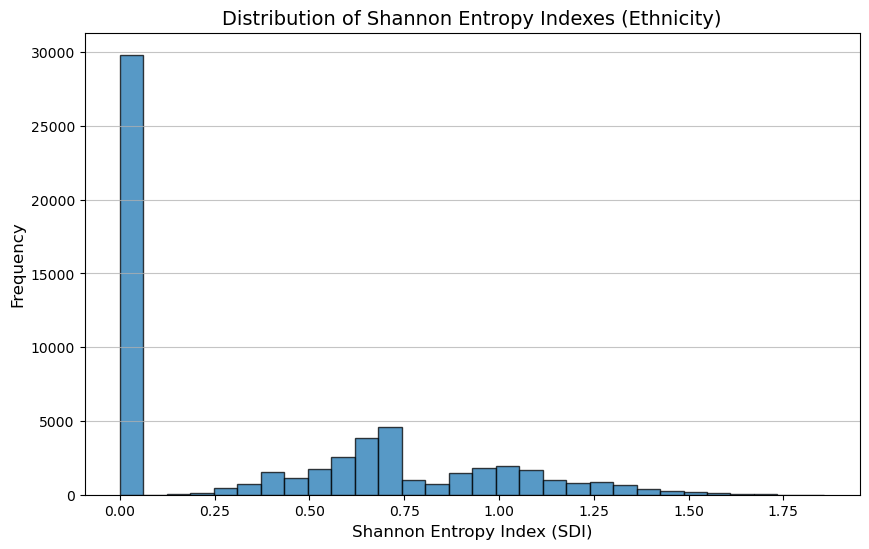

In [224]:
# Plot the distribution of Shannon entropy indexes
plt.figure(figsize=(10, 6))
plt.hist(df_ethnicity_counts['SDI_ethnicity'], bins=30, alpha=0.75, edgecolor='black')
plt.title('Distribution of Shannon Entropy Indexes (Ethnicity)', fontsize=14)
plt.xlabel('Shannon Entropy Index (SDI)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', alpha=0.75)
plt.show()

High values = High diversity and balanced distribution of the ethnicities of the cast, no dominance of one ethnicity over the others. 
Lower value = No diversity / All cast members have the same one ethnicity. 

## 2-Gender Score 

## A -Shannon diversity index

In [225]:
df_characters_gender = df_characters.dropna(subset=['actor_gender'])

In [226]:
# For Gender Diversity Index (SDI)
# Ooccurrences of each gender per movie
gender_counts = df_characters_gender.groupby(['wikipedia_id', 'actor_gender']).size().reset_index(name='gender_count')
# Total number of actors per movie
total_actors_per_movie = df_characters_gender.groupby('wikipedia_id').size().reset_index(name='total_actors')
#Merge the counts back into a single dataframe
df_gender_counts = gender_counts.merge(total_actors_per_movie, on='wikipedia_id')
# Proportions for each gender
df_gender_counts['gender_proportion'] = df_gender_counts['gender_count'] / df_gender_counts['total_actors']

# Step 5: Calculate SDI for each movie
df_sdi_gender = df_gender_counts.groupby('wikipedia_id').apply(
    lambda group: shannon_entropy(group['gender_proportion'])
).reset_index(name='SDI_gender')

# Merge the SDI scores back
df_gender_counts = df_gender_counts.merge(df_sdi_gender, on='wikipedia_id')
#dropping duplicates keeping unique entry per movie 
df_gender_counts = df_gender_counts.drop_duplicates(subset='wikipedia_id')
df_gender_counts.head()


C:\Users\bosca\AppData\Local\Temp\ipykernel_21364\2184839285.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sdi_gender = df_gender_counts.groupby('wikipedia_id').apply(


,wikipedia_id,actor_gender,gender_count,total_actors,gender_proportion,SDI_gender
0,330,F,4,4,1.000000,-0.000000
1,3217,F,3,13,0.230769,0.540204
3,3333,F,6,15,0.400000,0.673012
5,3746,F,3,14,0.214286,0.519580
7,3837,F,2,20,0.100000,0.325083


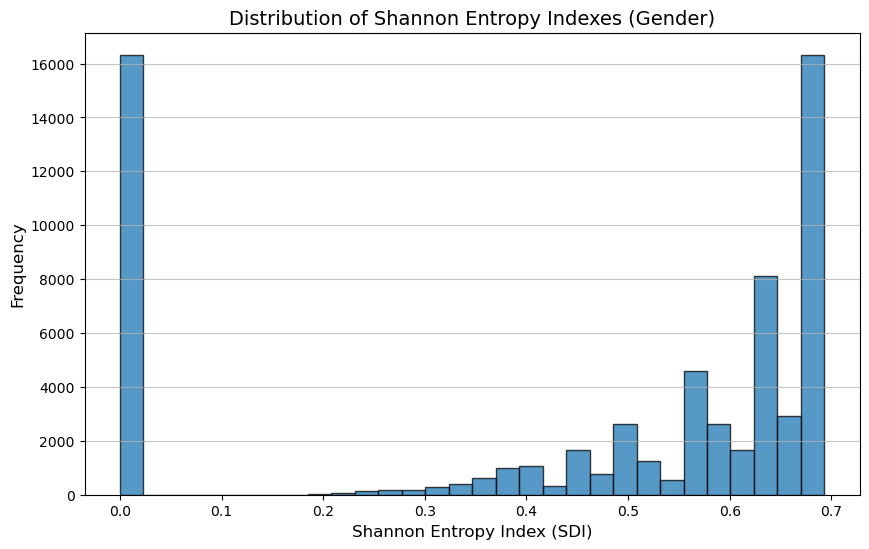

In [227]:
# Plot the distribution of Shannon entropy indexes
plt.figure(figsize=(10, 6))
plt.hist(df_gender_counts['SDI_gender'], bins=30, alpha=0.75, edgecolor='black')
plt.title('Distribution of Shannon Entropy Indexes (Gender)', fontsize=14)
plt.xlabel('Shannon Entropy Index (SDI)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', alpha=0.75)
plt.show()

Here, many films cluster around a moderate to relatively high SDI (around 0.6–0.7), suggesting that a substantial portion have a fairly mixed gender distribution, while a noticeable subset score near zero, indicating casts composed of only one gender.

## Now back to the original data frame: 

Adding Diversity and gender scores to original master dataframe. 

In [228]:
# Merge SDI_ethnicity
df_movies_tmdb_ratings = df_movies_tmdb_ratings.merge(
    df_ethnicity_counts[['wikipedia_id', 'SDI_ethnicity']],
    on='wikipedia_id',
    how='left'
)
# Merge SDI_gender and GPR
df_movies_tmdb_ratings = df_movies_tmdb_ratings.merge(
    df_gender_counts[['wikipedia_id', 'SDI_gender']],
    on='wikipedia_id',
    how='left'
)


In [229]:
# Adding nb of actors per movie:
#Number of actors per movie: 
# Unique actors per movie as each entry of df_characters is a character in the movie 
actors_per_movie = df_characters.groupby('wikipedia_id')['freebase_actor_id'].nunique()
# Map the count back to the original dataframe
df_movies_tmdb_ratings['nb_actors'] = df_movies_tmdb_ratings['wikipedia_id'].map(actors_per_movie)

## Nb of languages per movie matters? 

In [230]:
# Explode the languages column so each language gets its own row
df_languages_exploded = df_movies_tmdb_ratings_unique.explode('spoken_languages')
# Group by language and calculate the mean rating
mean_rating_per_language = df_languages_exploded.groupby('spoken_languages')['averageRating'].mean().reset_index()
# Sort by rating to see the most and least impactful languages
mean_rating_per_language = mean_rating_per_language.sort_values(by='averageRating', ascending=False)
print(mean_rating_per_language.head())


                                      spoken_languages  averageRating
306                                           Hariyani            9.2
483  Latin Language,Italian Language,Sicilian Langu...            9.2
242  French Language,Polish Language,Hebrew Languag...            9.0
404  Italian Language,English Language,Latin Langua...            9.0
339     Hindi Language,Gujarati Language,Urdu Language            8.7


We add filter empty lists of spoken languages and drop na_s and see if the nb of spoken languages is correlated to the mean rating

In [231]:
# Drop rows where spoken_languages is NaN
df_movies_with_languages = df_movies_tmdb_ratings_unique.dropna(subset=['spoken_languages'])
# Drop rows where spoken_languages is an empty list
df_movies_with_languages = df_movies_with_languages[
    df_movies_with_languages['spoken_languages'].apply(lambda x: len(x) > 0)
]

# Check the resulting dataframe
print(df_movies_with_languages[['wikipedia_id', 'spoken_languages']].head())


       wikipedia_id                                  spoken_languages
5664        4213160                                  English Language
23058      10331139                                  English Language
31498      13504095                      Silent film,English Language
18883       3610422                                  English Language
21489      16038391  French Language,English Language,German Language


In [232]:
# Count the number of languages per movie
df_movies_with_languages['nb_languages'] = df_movies_with_languages['spoken_languages'].apply(len)
# Check the updated dataframe
print(df_movies_with_languages[['wikipedia_id', 'averageRating', 'nb_languages']].head())


       wikipedia_id  averageRating  nb_languages
5664        4213160            6.3            16
23058      10331139            5.4            16
31498      13504095            3.3            28
18883       3610422            5.0            16
21489      16038391            6.7            48


In [233]:
from scipy.stats import pearsonr, spearmanr

# Drop rows with missing values in 'mean_rating' or 'nb_languages'
df_correlation_languages = df_movies_with_languages.dropna(subset=['averageRating', 'nb_languages'])
# Pearson correlation
pearson_corr, pearson_p = pearsonr(df_correlation_languages['nb_languages'], df_correlation_languages['averageRating'])
print(f"Pearson correlation: {pearson_corr:.4f}, p-value: {pearson_p:.4f}")

# Spearman correlation
spearman_corr, spearman_p = spearmanr(df_correlation_languages['nb_languages'], df_correlation_languages['averageRating'])
print(f"Spearman correlation: {spearman_corr:.4f}, p-value: {spearman_p:.4f}")


Pearson correlation: 0.0971, p-value: 0.0000
Spearman correlation: 0.0741, p-value: 0.0000


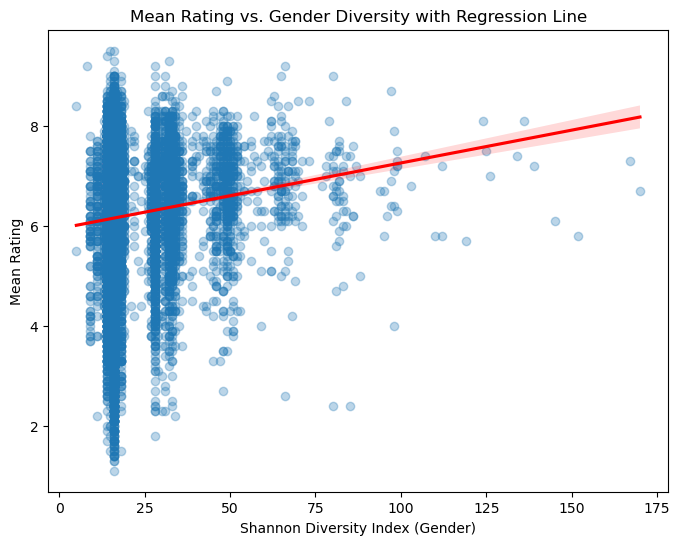

In [234]:
plt.figure(figsize=(8,6))
sns.regplot(
    x='nb_languages', 
    y='averageRating', 
    data=df_correlation_languages, 
    scatter_kws={'alpha':0.3}, 
    line_kws={'color':'red'}
)
plt.xlabel('Shannon Diversity Index (Gender)')
plt.ylabel('Mean Rating')
plt.title('Mean Rating vs. Gender Diversity with Regression Line')
plt.show()

In [235]:
df_movies_tmdb_ratings['nb_languages'] = df_movies_tmdb_ratings['spoken_languages'].apply(lambda x: len(x.split(',')) if x else 0)

In [236]:
# deleting not used dataframes (but keeping the original ones)
del df_filtered # df_characters without missing ethnicities
del df_ethnicity_exploded
del total_actors
del df_sdi

del df_characters_gender
del total_actors_per_movie
del df_sdi_gender

# Decision Tree Model

In [237]:
# Creating new binned rating column
df_movies_tmdb_ratings['binned_rating'] = df_movies_tmdb_ratings['averageRating'].round()

In [238]:
from sklearn.preprocessing import LabelEncoder

# keeping only some features and specifing the target variable
features = df_movies_tmdb_ratings[
    [
        'release_date',
        'revenue',
        'runtime',
        'genres',
        'budget',
        'genre_count',
        'region',
        'historical_proximity_score',
        'SDI_ethnicity',
        'SDI_gender',
        'nb_actors',
        'nb_languages'
    ]
]

target = df_movies_tmdb_ratings[['binned_rating']]

# encoding target variable to discrete classes
encoder = LabelEncoder()
target = encoder.fit_transform(target)

c:\Users\bosca\anaconda3\envs\ada\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [239]:
# one-hot encoding of some features (no dropping of the first column)
features = pd.get_dummies(features, columns=['release_date', 'genres', 'genre_count', 'region', 'nb_actors', 'nb_languages'], drop_first=True)

In [240]:
from sklearn.model_selection import train_test_split

# train-test split 80-20 ratio
df_train, df_test, df_train_target, df_test_target = train_test_split(
    features, 
    target, 
    test_size=0.2, 
    random_state=42
)

# The final number of values in the resulting training and testing dataframes is required
print(f'The number of samples in the train dataset is: {len(df_train)}')
print(f'The number of samples in the test dataset is: {len(df_test)}')

The number of samples in the train dataset is: 61197
The number of samples in the test dataset is: 15300


In [241]:
from sklearn.tree import DecisionTreeClassifier

# DecisionTreeClassifier call
decision_tree = DecisionTreeClassifier(random_state=42).fit(df_train, df_train_target)

In [242]:
# predicting test set
target_predict = decision_tree.predict(df_test)

# printing depth of the tree
D = decision_tree.get_depth()
print(f'The depth of the decision tree is: {D}')

The depth of the decision tree is: 91


In [243]:
from sklearn.metrics import classification_report

# evaluating metrics
print(classification_report(df_test_target, target_predict))

              precision    recall  f1-score   support

           0       0.80      0.67      0.73         6
           1       0.66      0.62      0.64        72
           2       0.55      0.52      0.54       222
           3       0.69      0.68      0.68       877
           4       0.73      0.73      0.73      2150
           5       0.79      0.81      0.80      6006
           6       0.76      0.77      0.76      4520
           7       0.73      0.66      0.69      1415
           8       0.36      0.31      0.33        32

    accuracy                           0.76     15300
   macro avg       0.67      0.64      0.66     15300
weighted avg       0.76      0.76      0.76     15300



The best depth in terms of accuracy is: 89


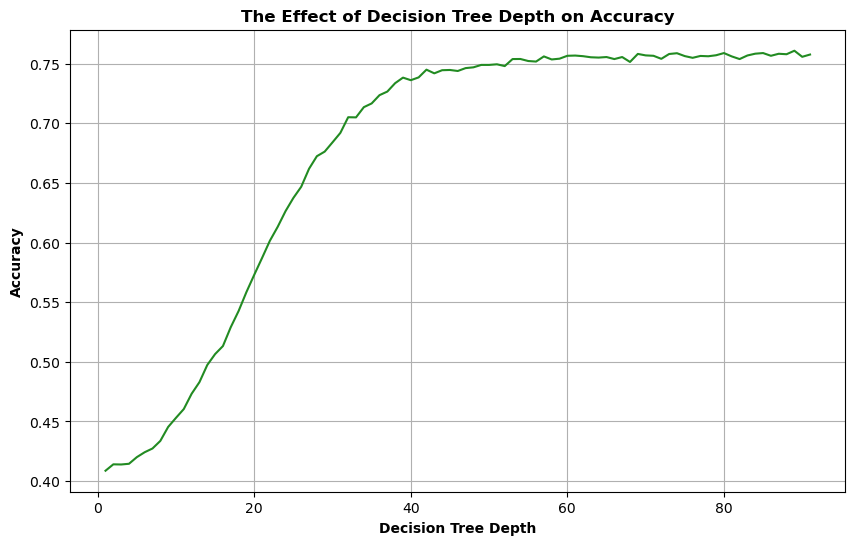

In [244]:
from sklearn.metrics import accuracy_score

# searching D that maximizes accuracy of the model
accuracies = np.zeros(D)

for d in range(0, D):
    decision_tree = DecisionTreeClassifier(max_depth=d+1, random_state=42).fit(df_train, df_train_target)

    # predicting outcomes
    target_predict = decision_tree.predict(df_test)
    accuracies[d] = accuracy_score(df_test_target, target_predict)

# plotting results
plt.figure(figsize=(10, 6))
plt.plot(range(1, D+1), accuracies,  '-', color='forestgreen')
plt.xlabel('Decision Tree Depth',  weight='bold')
plt.ylabel('Accuracy',  weight='bold')
plt.title('The Effect of Decision Tree Depth on Accuracy', weight='bold')
plt.grid(True)

# getting best tree depth
best_acc = np.max(accuracies)
best_d = np.where(accuracies == best_acc)[0]

print(f'The best depth in terms of accuracy is: {best_d[0]+1}')

In [245]:
from sklearn.ensemble import RandomForestClassifier

# train-test split 80-20 ratio
df_train, df_test, df_train_target, df_test_target = train_test_split(
    features, 
    target, 
    test_size=0.2, 
    random_state=42
)

# The final number of values in the resulting training and testing dataframes is required
print(f'The number of samples in the train dataset is: {len(df_train)}')
print(f'The number of samples in the test dataset is: {len(df_test)}')

# Create the model
random_forest = RandomForestClassifier()

# Train the model
random_forest.fit(df_train, df_train_target)

# prediction
target_predict = random_forest.predict(df_test)

# Accuracy
accuracy = accuracy_score(df_test_target, target_predict)
print(f"Accuracy: {accuracy}")

The number of samples in the train dataset is: 61197
The number of samples in the test dataset is: 15300
Accuracy: 0.756078431372549


In [246]:
# Retrieve feature importances
importances = random_forest.feature_importances_

# Display feature importances
for i, importance in enumerate(importances):
    print(f"Feature {i} ({features.columns[i]}): {importance}")

Feature 0 (revenue): 0.030670956428056437
Feature 1 (runtime): 0.13318642001633296
Feature 2 (budget): 0.02624045773902844
Feature 3 (historical_proximity_score): 0.04870955870651089
Feature 4 (SDI_ethnicity): 0.06514885054531151
Feature 5 (SDI_gender): 0.07109832290691981
Feature 6 (release_date_1889): 4.115295713128747e-05
Feature 7 (release_date_1890): 3.678489291524941e-05
Feature 8 (release_date_1891): 2.099698227549634e-05
Feature 9 (release_date_1893): 9.483336276465836e-06
Feature 10 (release_date_1894): 0.0003201462131486135
Feature 11 (release_date_1895): 9.83177993643296e-05
Feature 12 (release_date_1896): 0.0002796866506452633
Feature 13 (release_date_1897): 3.5664105336313046e-05
Feature 14 (release_date_1898): 8.262668352871553e-05
Feature 15 (release_date_1899): 6.853834980771997e-05
Feature 16 (release_date_1900): 0.00022302380720617244
Feature 17 (release_date_1901): 0.00010774894037689086
Feature 18 (release_date_1902): 3.8998995868650255e-05
Feature 19 (release_date_

k-fold cross validation on random forest:

In [247]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(random_forest, df_train, df_train_target, cv=10)  # 5-fold CV
print(f"Cross-Validation Scores: {scores}")
print(f"Mean Score: {scores.mean()}")

c:\Users\bosca\anaconda3\envs\ada\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


Cross-Validation Scores: [0.73643791 0.72271242 0.7369281  0.73415033 0.74395425 0.74117647
 0.73186275 0.74881517 0.73688511 0.74048047]
Mean Score: 0.7373402970710538


In [248]:
scores = cross_val_score(DecisionTreeClassifier(), df_train, df_train_target, cv=10)  # 5-fold CV
print(f"Cross-Validation Scores: {scores}")
print(f"Mean Score: {scores.mean()}")

c:\Users\bosca\anaconda3\envs\ada\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


Cross-Validation Scores: [0.71895425 0.7127451  0.72843137 0.73169935 0.73218954 0.73349673
 0.73088235 0.73802909 0.7110639  0.74603693]
Mean Score: 0.7283528616000521
